In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

sns.set()
sns.set_style("whitegrid")


In [13]:
import matplotlib.colors as colors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap


cmap_64 = plt.get_cmap("Blues")
cmap_64 = truncate_colormap(cmap_64, 0.3, 0.9)
cmap_32 = plt.get_cmap("Oranges")
cmap_32 = truncate_colormap(cmap_32, 0.3, 0.9)
cmap_16 = plt.get_cmap("Greens")
cmap_16 = truncate_colormap(cmap_16, 0.3, 0.9)


In [14]:
cu_data = pd.read_csv("../data/spsv-cusparse12-4090.csv",
                      header=None,
                      names=[
                          "cu_pro", "mat", "x", "y", "compute", "m", "n",
                          "nnz", "cu_time", "cu_gflops"
                      ])
work_est = pd.read_csv("../data/level-info.csv",
                       header=None,
                       names=[
                           "mat", "nlevel", "parallelism_min",
                           "parallelism_avg", "parallelism_max"
                       ])
cu_data = cu_data.loc[:, ["cu_pro", "mat", "nnz", "cu_time", "cu_gflops"]]

cu_data = pd.merge(cu_data, work_est, how='inner', on='mat')
# print(cu_data)

cu_info = cu_data["cu_pro"].unique()

for diff_pro in cu_info:
    temp_data = cu_data[cu_data["cu_pro"].isin([diff_pro])]
    exec("%s=temp_data.copy()" % diff_pro)
print(cu_info)

['exe_sptrsv_csr_32' 'exe_sptrsv_csr_64']


In [15]:
print(exe_sptrsv_csr_32)

                 cu_pro                                                mat  \
0     exe_sptrsv_csr_32       /ssget/MM/Szczerba/Ill_Stokes/Ill_Stokes.cbd   
2     exe_sptrsv_csr_32          /ssget/MM/Freescale/FullChip/FullChip.cbd   
4     exe_sptrsv_csr_32      /ssget/MM/Freescale/Freescale1/Freescale1.cbd   
6     exe_sptrsv_csr_32  /ssget/MM/Freescale/circuit5M_dc/circuit5M_dc.cbd   
8     exe_sptrsv_csr_32        /ssget/MM/Freescale/transient/transient.cbd   
...                 ...                                                ...   
4234  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_3/CurlCurl_3.cbd   
4236  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_4/CurlCurl_4.cbd   
4238  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_1/CurlCurl_1.cbd   
4240  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_0/CurlCurl_0.cbd   
4242  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_2/CurlCurl_2.cbd   

           nnz  cu_time  cu_gflops  nlevel  parallelism_min  pa

In [16]:
# Collect the 32-bit data

regex_mat = '(?<=exe_sptrsv_csr_32,).[a-zA-Z0-9\.\/\-_]*'
regex_L1 = '(?<="L1/TEX Hit Rate","%",").[.0-9_]*'
regex_L2 = '(?<=L2 Hit Rate","%",").[.0-9_]*'
regex_mpb = '(?<="Mem Pipes Busy","%",").[.0-9_]*'
regex_mb = '(?<="Mem Busy","%",").[.0-9_]*'
regex_sb = '(?<="SM Busy","%",").[.0-9_]*'
regex_2t = '(?<="L2 Cache Throughput","%",").[.0-9_]*'

sptrsv_mat_32 = []
sptrsv_L1_32 = []
sptrsv_L2_32 = []
sptrsv_mpb_32 = []
sptrsv_mb_32 = []
sptrsv_sb_32 = []
sptrsv_2t_32 = []

fileHandler = open("../data/ncu-sptrsv-cusparse-4090.csv", "r")

while True:
    line = fileHandler.readline()
    if not line:
        break
    if not line.startswith("exe_sptrsv_csr_32"):
        continue

    str_select = re.findall(regex_mat, line)
    sptrsv_mat_32.append(str_select)

    str_select = re.findall(regex_L1, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_L1_32.append(np.mean(num_list_new))

    str_select = re.findall(regex_L2, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_L2_32.append(np.mean(num_list_new))

    str_select = re.findall(regex_mpb, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_mpb_32.append(np.mean(num_list_new))

    str_select = re.findall(regex_mb, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_mb_32.append(np.mean(num_list_new))

    str_select = re.findall(regex_sb, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_sb_32.append(np.mean(num_list_new))

    str_select = re.findall(regex_2t, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_2t_32.append(np.mean(num_list_new))

fileHandler.close()

df_sptrsv_mat_32 = pd.DataFrame(sptrsv_mat_32, columns=['mat'])
df_sptrsv_L1_32 = pd.DataFrame(sptrsv_L1_32, columns=['L1_rate'])
df_sptrsv_L2_32 = pd.DataFrame(sptrsv_L2_32, columns=['L2_rate'])
df_sptrsv_mpb_32 = pd.DataFrame(sptrsv_mpb_32, columns=['mem_pipe_busy'])
df_sptrsv_mb_32 = pd.DataFrame(sptrsv_mb_32, columns=['mem_busy'])
df_sptrsv_sb_32 = pd.DataFrame(sptrsv_sb_32, columns=['sm_busy'])
df_sptrsv_2t_32 = pd.DataFrame(sptrsv_2t_32, columns=['L2_throughput'])

df_sptrsv_ncu_32 = pd.concat([
    df_sptrsv_mat_32, df_sptrsv_L1_32, df_sptrsv_L2_32, df_sptrsv_mpb_32,
    df_sptrsv_mb_32, df_sptrsv_sb_32, df_sptrsv_2t_32
],
                             axis=1)

df_all_32 = pd.merge(exe_sptrsv_csr_32,
                     df_sptrsv_ncu_32,
                     on="mat",
                     how="inner")

print(df_all_32)


                 cu_pro                                                mat  \
0     exe_sptrsv_csr_32       /ssget/MM/Szczerba/Ill_Stokes/Ill_Stokes.cbd   
1     exe_sptrsv_csr_32          /ssget/MM/Freescale/FullChip/FullChip.cbd   
2     exe_sptrsv_csr_32      /ssget/MM/Freescale/Freescale1/Freescale1.cbd   
3     exe_sptrsv_csr_32  /ssget/MM/Freescale/circuit5M_dc/circuit5M_dc.cbd   
4     exe_sptrsv_csr_32        /ssget/MM/Freescale/transient/transient.cbd   
...                 ...                                                ...   
2118  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_3/CurlCurl_3.cbd   
2119  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_4/CurlCurl_4.cbd   
2120  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_1/CurlCurl_1.cbd   
2121  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_0/CurlCurl_0.cbd   
2122  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_2/CurlCurl_2.cbd   

           nnz  cu_time  cu_gflops  nlevel  parallelism_min  pa

In [17]:
# Collect the 64-bit data

regex_mat = '(?<=exe_sptrsv_csr_64,).[a-zA-Z0-9\.\/\-_]*'
regex_L1 = '(?<="L1/TEX Hit Rate","%",").[.0-9_]*'
regex_L2 = '(?<="L2 Hit Rate","%",").[.0-9_]*'
regex_mpb = '(?<="Mem Pipes Busy","%",").[.0-9_]*'
regex_mb = '(?<="Mem Busy","%",").[.0-9_]*'
regex_sb = '(?<="SM Busy","%",").[.0-9_]*'
regex_2t = '(?<="L2 Cache Throughput","%",").[.0-9_]*'

sptrsv_mat_64 = []
sptrsv_L1_64 = []
sptrsv_L2_64 = []
sptrsv_mpb_64 = []
sptrsv_mb_64 = []
sptrsv_sb_64 = []
sptrsv_2t_64 = []

fileHandler = open("../data/ncu-sptrsv-cusparse-4090.csv", "r")

while True:
    line = fileHandler.readline()
    if not line:
        break
    if not line.startswith("exe_sptrsv_csr_64"):
        continue

    str_select = re.findall(regex_mat, line)
    sptrsv_mat_64.append(str_select)

    str_select = re.findall(regex_L1, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_L1_64.append(np.mean(num_list_new))

    str_select = re.findall(regex_L2, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_L2_64.append(np.mean(num_list_new))

    str_select = re.findall(regex_mpb, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_mpb_64.append(np.mean(num_list_new))

    str_select = re.findall(regex_mb, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_mb_64.append(np.mean(num_list_new))

    str_select = re.findall(regex_sb, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_sb_64.append(np.mean(num_list_new))

    str_select = re.findall(regex_2t, line)
    num_list_new = [float(i) for i in str_select]
    sptrsv_2t_64.append(np.mean(num_list_new))

fileHandler.close()

df_sptrsv_mat_64 = pd.DataFrame(sptrsv_mat_64, columns=['mat'])
df_sptrsv_L1_64 = pd.DataFrame(sptrsv_L1_64, columns=['L1_rate'])
df_sptrsv_L2_64 = pd.DataFrame(sptrsv_L2_64, columns=['L2_rate'])
df_sptrsv_mpb_64 = pd.DataFrame(sptrsv_mpb_64, columns=['mem_pipe_busy'])
df_sptrsv_mb_64 = pd.DataFrame(sptrsv_mb_64, columns=['mem_busy'])
df_sptrsv_sb_64 = pd.DataFrame(sptrsv_sb_64, columns=['sm_busy'])
df_sptrsv_2t_64 = pd.DataFrame(sptrsv_2t_64, columns=['L2_throughput'])

df_sptrsv_ncu_64 = pd.concat([
    df_sptrsv_mat_64, df_sptrsv_L1_64, df_sptrsv_L2_64, df_sptrsv_mpb_64,
    df_sptrsv_mb_64, df_sptrsv_sb_64, df_sptrsv_2t_64
],
                             axis=1)

df_all_64 = pd.merge(exe_sptrsv_csr_64,
                     df_sptrsv_ncu_64,
                     on="mat",
                     how="inner")

print(df_all_64)


                 cu_pro                                                mat  \
0     exe_sptrsv_csr_64       /ssget/MM/Szczerba/Ill_Stokes/Ill_Stokes.cbd   
1     exe_sptrsv_csr_64          /ssget/MM/Freescale/FullChip/FullChip.cbd   
2     exe_sptrsv_csr_64      /ssget/MM/Freescale/Freescale1/Freescale1.cbd   
3     exe_sptrsv_csr_64  /ssget/MM/Freescale/circuit5M_dc/circuit5M_dc.cbd   
4     exe_sptrsv_csr_64        /ssget/MM/Freescale/transient/transient.cbd   
...                 ...                                                ...   
2116  exe_sptrsv_csr_64      /ssget/MM/Bodendiek/CurlCurl_3/CurlCurl_3.cbd   
2117  exe_sptrsv_csr_64      /ssget/MM/Bodendiek/CurlCurl_4/CurlCurl_4.cbd   
2118  exe_sptrsv_csr_64      /ssget/MM/Bodendiek/CurlCurl_1/CurlCurl_1.cbd   
2119  exe_sptrsv_csr_64      /ssget/MM/Bodendiek/CurlCurl_0/CurlCurl_0.cbd   
2120  exe_sptrsv_csr_64      /ssget/MM/Bodendiek/CurlCurl_2/CurlCurl_2.cbd   

           nnz  cu_time  cu_gflops  nlevel  parallelism_min  pa

In [18]:
cu_data_comp = pd.merge(df_all_64,
                        df_all_32,
                        how='inner',
                        on='mat',
                        suffixes=("_64", "_32"))

cu_data_comp = cu_data_comp.loc[:, [
    "mat", "cu_gflops_64", "cu_gflops_32", "parallelism_avg_64"
]]

cu_data_comp[
    "speedup_32"] = cu_data_comp["cu_gflops_32"] / cu_data_comp["cu_gflops_64"]
print(cu_data_comp)

                                                    mat  cu_gflops_64  \
0          /ssget/MM/Szczerba/Ill_Stokes/Ill_Stokes.cbd      9.861226   
1             /ssget/MM/Freescale/FullChip/FullChip.cbd     47.838466   
2         /ssget/MM/Freescale/Freescale1/Freescale1.cbd     36.259900   
3     /ssget/MM/Freescale/circuit5M_dc/circuit5M_dc.cbd     31.926605   
4           /ssget/MM/Freescale/transient/transient.cbd     19.424417   
...                                                 ...           ...   
2116      /ssget/MM/Bodendiek/CurlCurl_3/CurlCurl_3.cbd     20.672639   
2117      /ssget/MM/Bodendiek/CurlCurl_4/CurlCurl_4.cbd     28.881941   
2118      /ssget/MM/Bodendiek/CurlCurl_1/CurlCurl_1.cbd      8.504639   
2119      /ssget/MM/Bodendiek/CurlCurl_0/CurlCurl_0.cbd      0.724123   
2120      /ssget/MM/Bodendiek/CurlCurl_2/CurlCurl_2.cbd     16.545040   

      cu_gflops_32  parallelism_avg_64  speedup_32  
0        13.747454              1393.0    1.394092  
1        68.75293

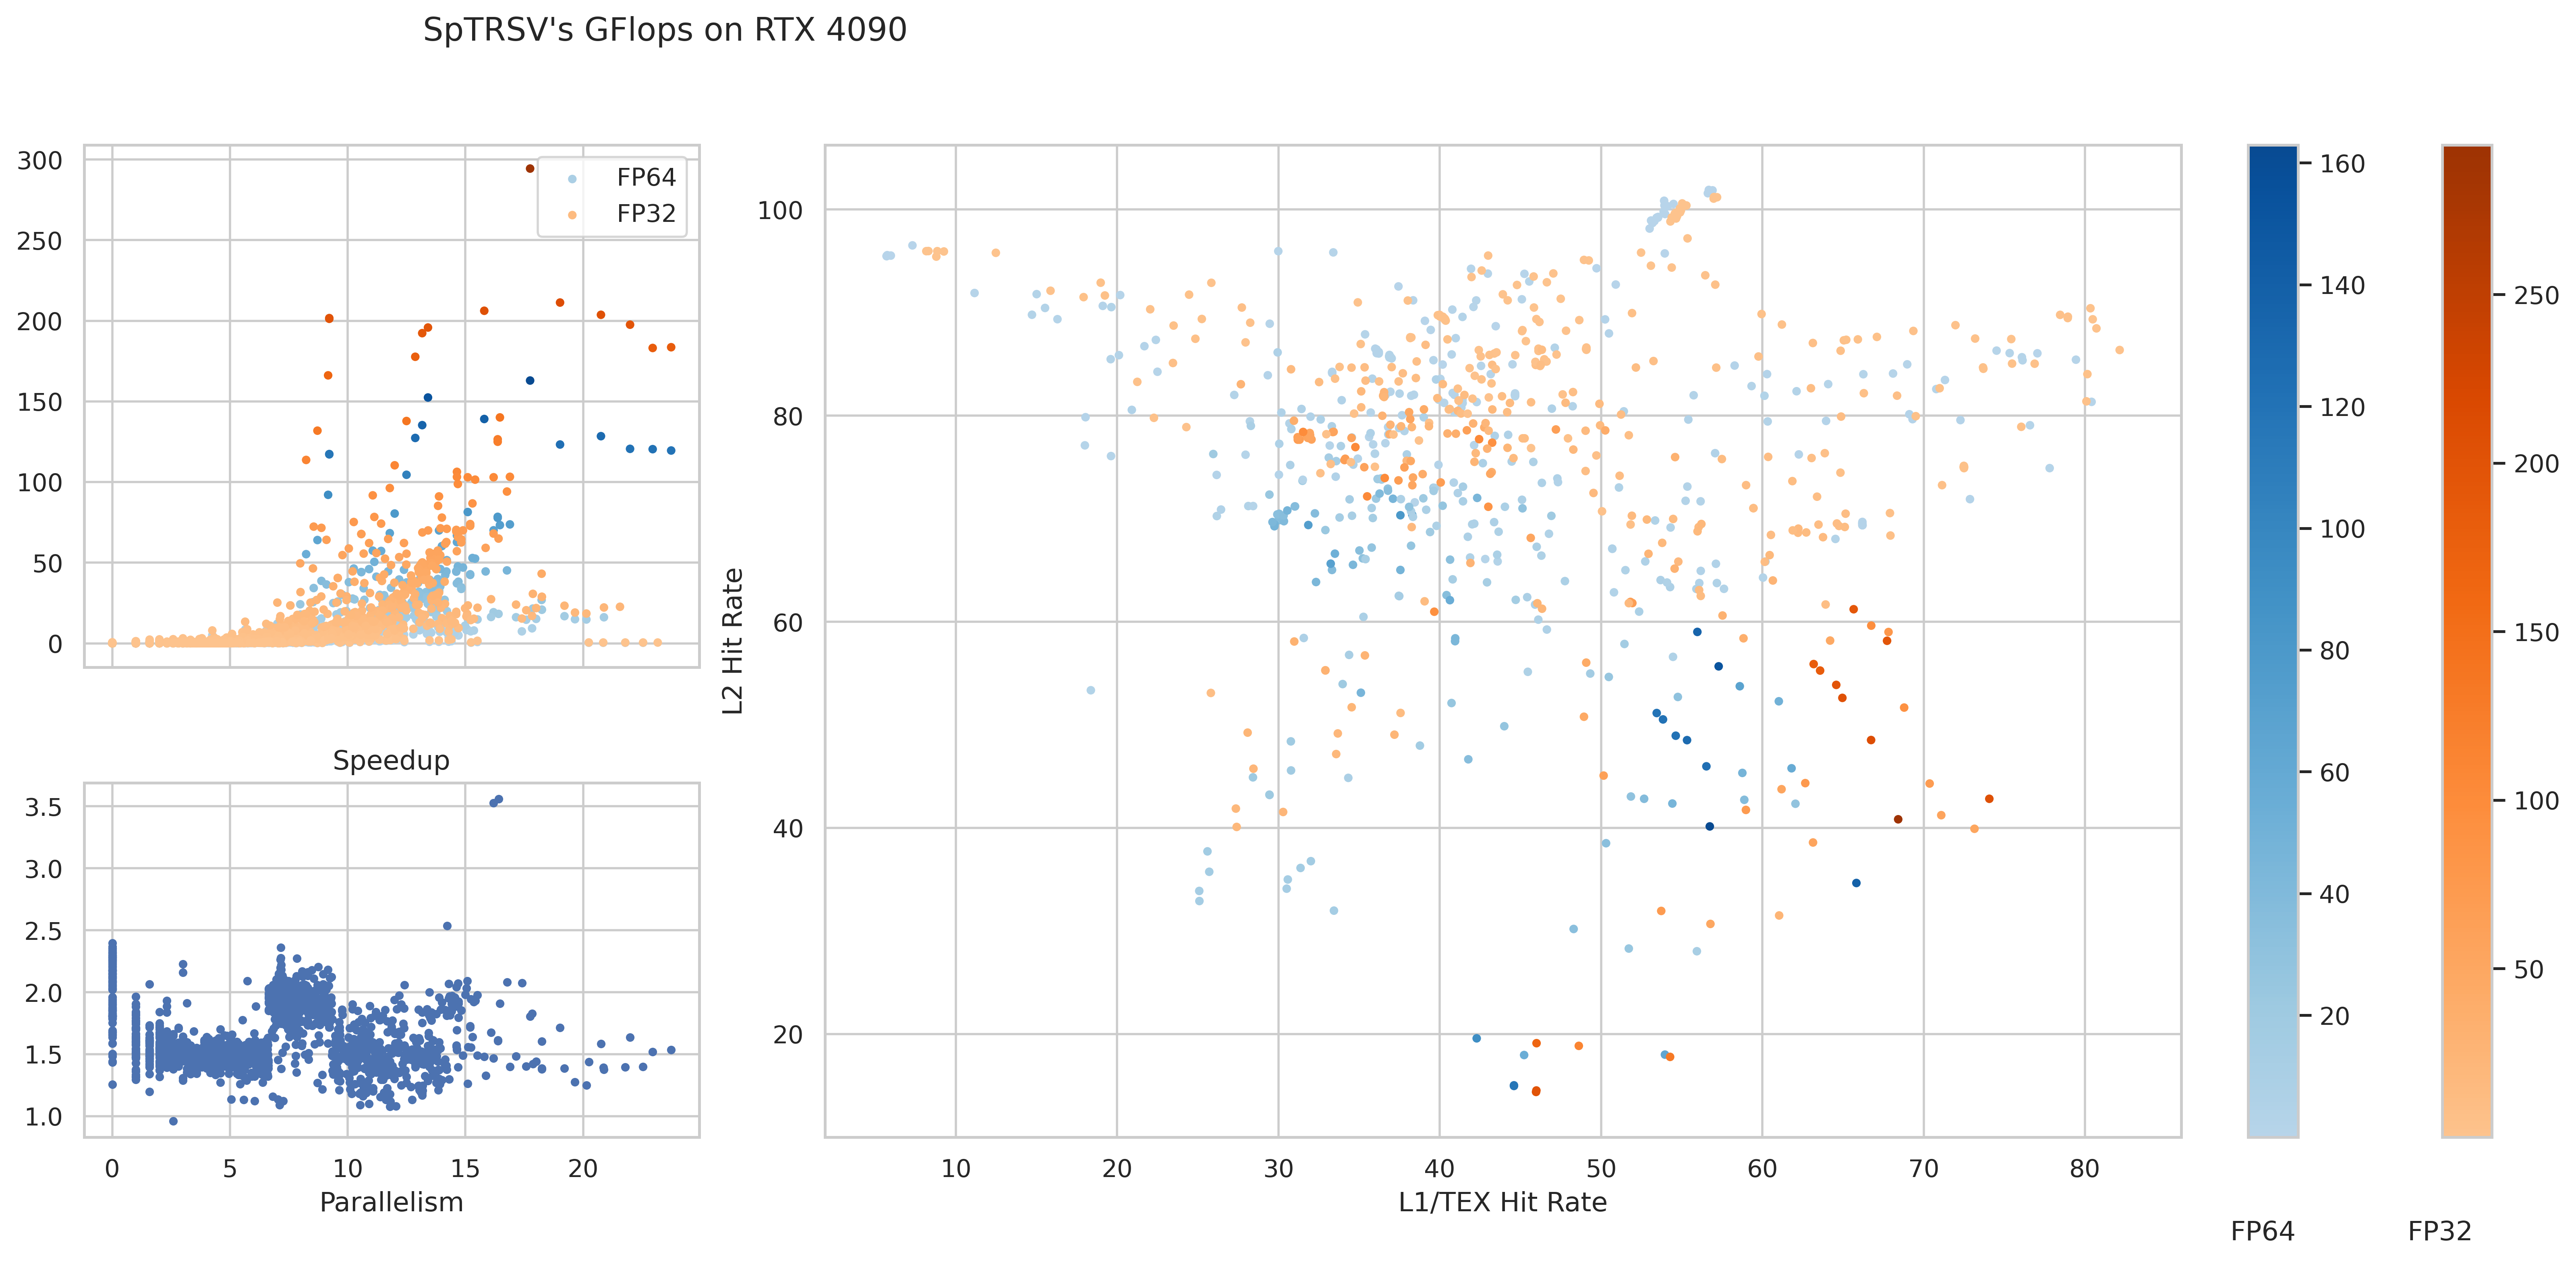

In [19]:
# %matplotlib notebook 
%matplotlib inline

# plt.figure(figsize=(18, 4), dpi=400)
# plt.subplots_adjust(right=None, left=None,wspace=0.2, hspace=0)

plt.figure(figsize=(32, 8), dpi=400)
plt.subplots_adjust(right=None, left=None,wspace=0.1, hspace=-0.1)

mark_size= 8

plt.subplot(2,6,3)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

plt.legend()


plt.subplot(3,6,15)

plt.scatter(np.log2(cu_data_comp["parallelism_avg_64"]),
            (cu_data_comp["speedup_32"]),
            label="cuSPARSE\nFP32 speedup over FP64",
            cmap=cmap_32,
            s=mark_size)

plt.title("Speedup")
plt.xlabel("Parallelism")

plt.subplot(122)

df_all_64_big=df_all_64.loc[(df_all_64["nnz"] > 2**20)].copy()
df_all_32_big=df_all_32.loc[(df_all_32["nnz"] > 2**20)].copy()

fp64 = plt.scatter(df_all_64_big["L1_rate"],df_all_64_big["L2_rate"], c=df_all_64_big["cu_gflops"], cmap=cmap_64, s=mark_size)
fp32 = plt.scatter(df_all_32_big["L1_rate"],df_all_32_big["L2_rate"], c=df_all_32_big["cu_gflops"], cmap=cmap_32, s=mark_size)

plt.xlabel("L1/TEX Hit Rate")
plt.ylabel("L2 Hit Rate")

plt.colorbar(fp32, pad=-0.03)
plt.colorbar(fp64, pad=0.04)

# plt.text(89, -5, "FP64")
# plt.text(100,-5, "FP32")
plt.text(89, 0, "FP64")
plt.text(100,0, "FP32")


plt.suptitle("SpTRSV's GFlops on RTX 4090")

plt.savefig("sptrsv_cusparse_hit_4090.pdf",
            dpi=400,
            format="pdf",
            bbox_inches='tight',
            pad_inches=0.0)

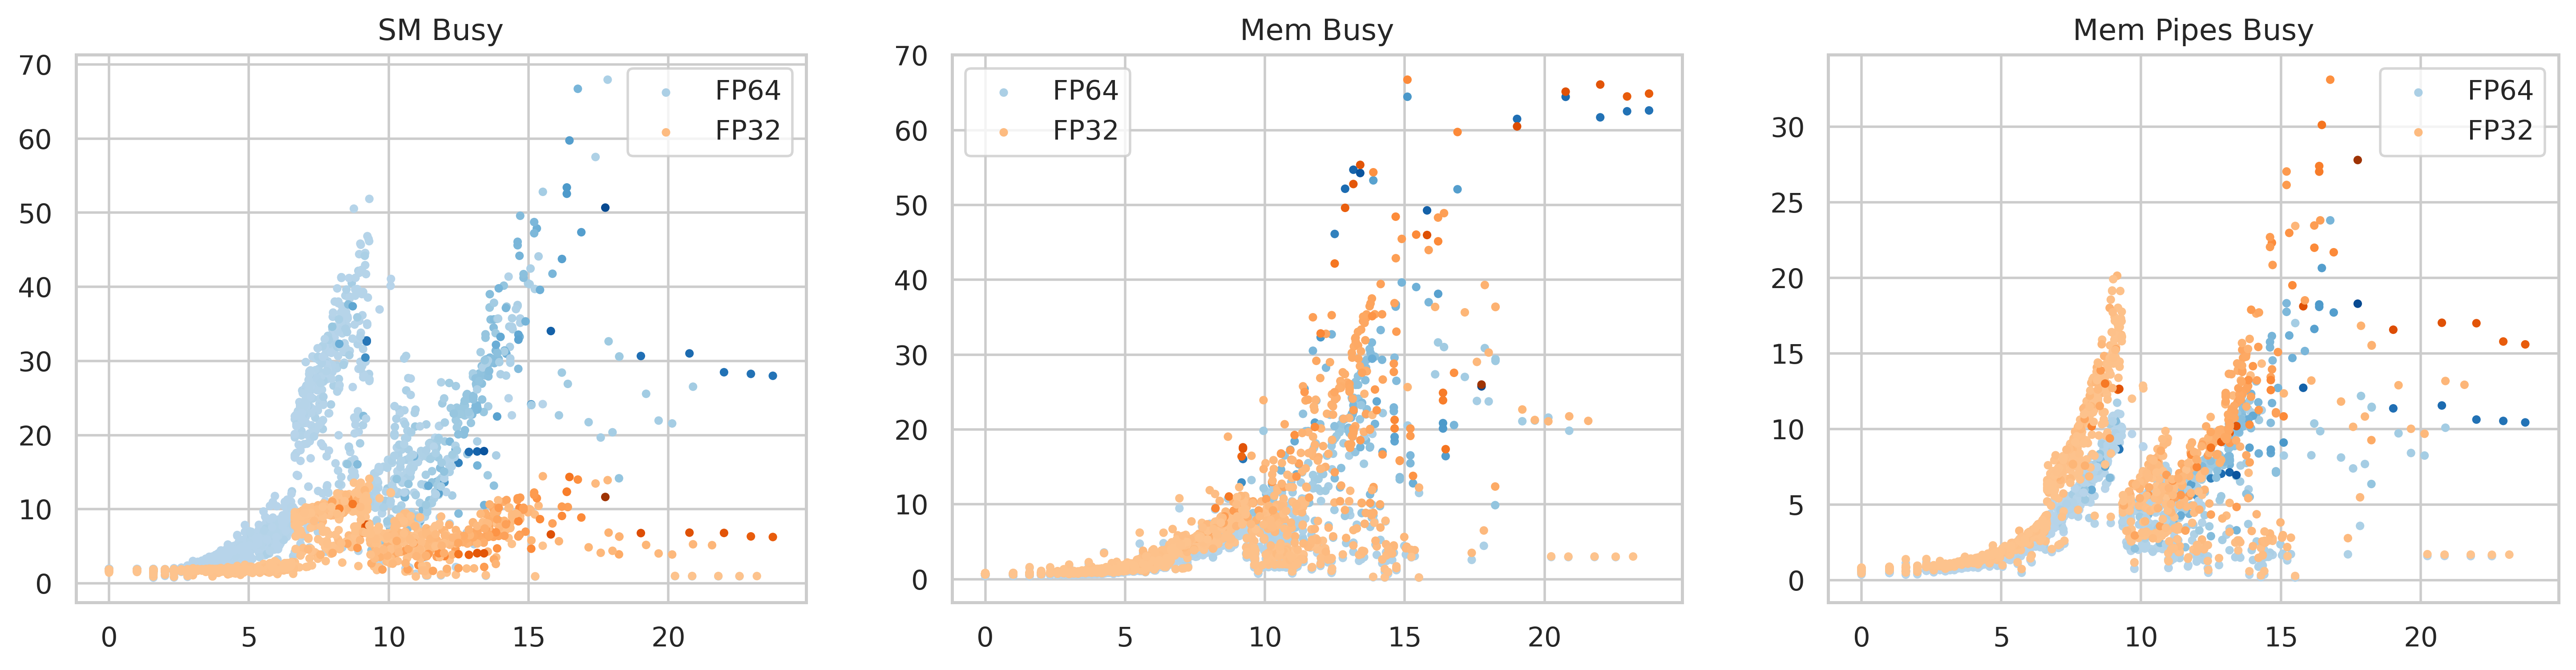

In [20]:
%matplotlib inline

plt.figure(figsize=(18, 4), dpi=400)
# plt.subplots_adjust(right=None, left=None,wspace=0.2, hspace=0)

mark_size= 6

plt.subplot(1,3,1)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["sm_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["sm_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("SM Busy")

plt.subplot(1,3,2)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("Mem Busy")

plt.subplot(1,3,3)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_pipe_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_pipe_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("Mem Pipes Busy")

plt.show()

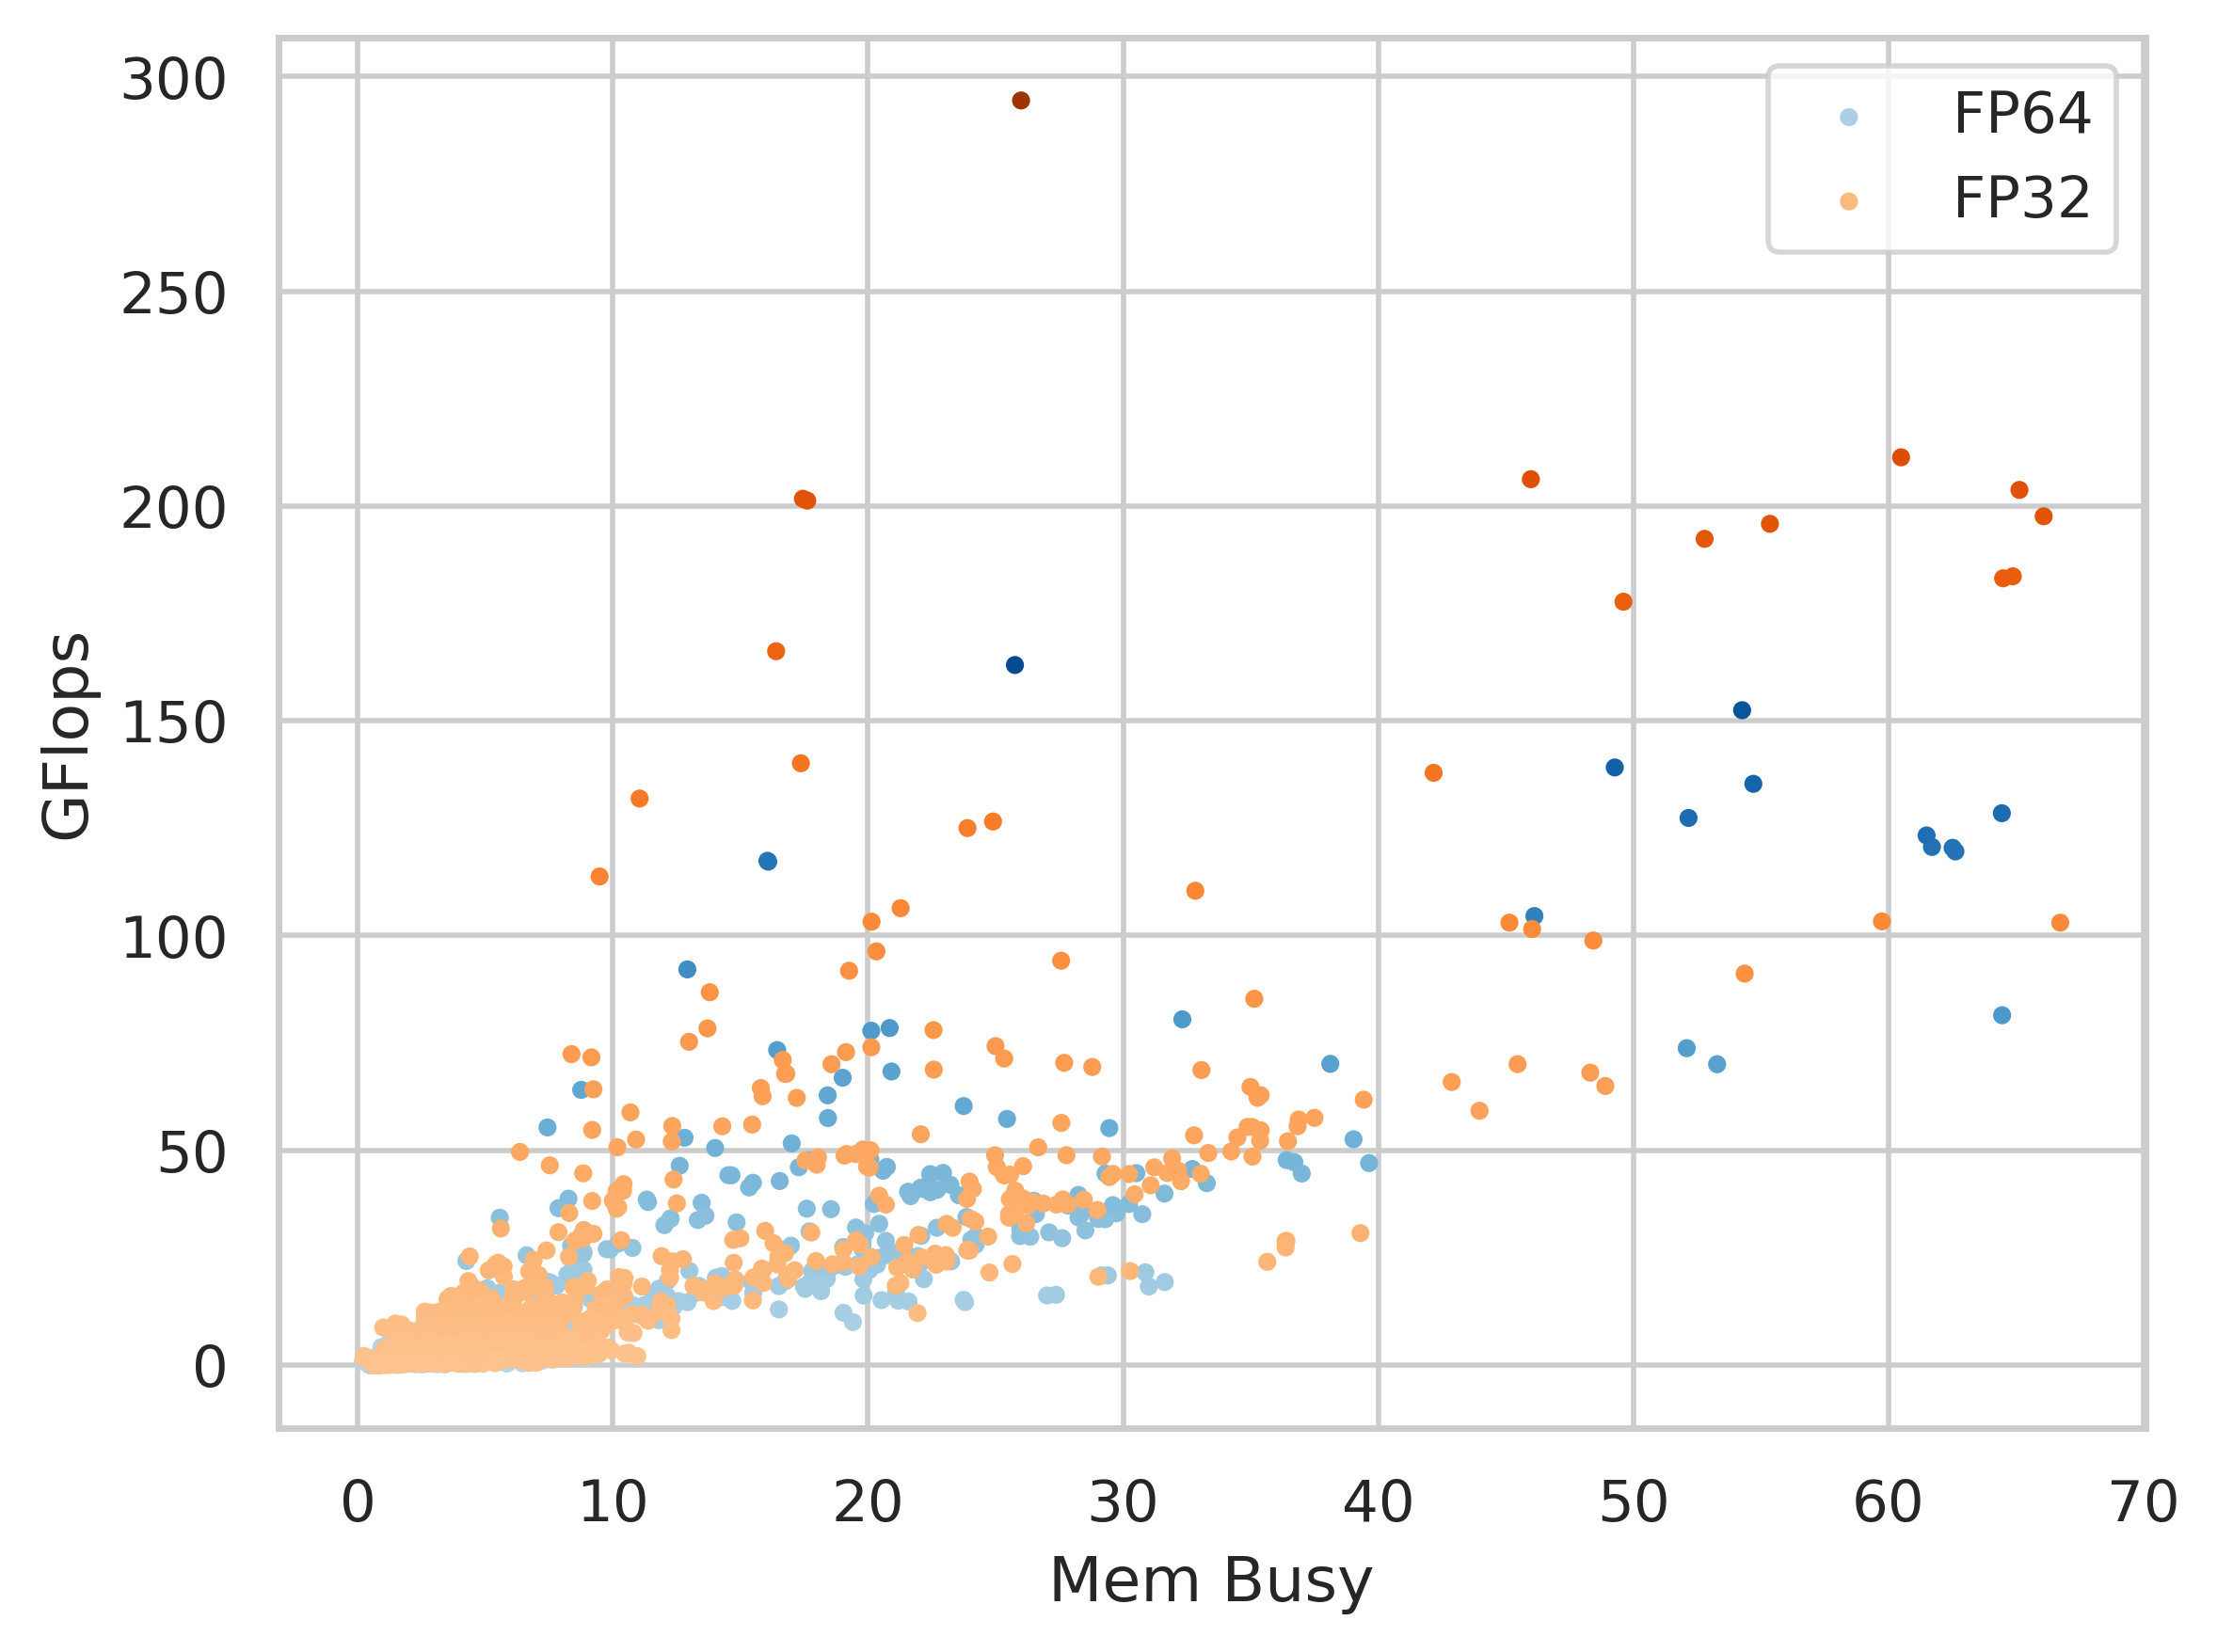

In [21]:
plt.figure(dpi=400)

plt.scatter(
    (df_all_64["mem_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    (df_all_32["mem_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Mem Busy")
plt.ylabel("GFlops")

plt.legend()


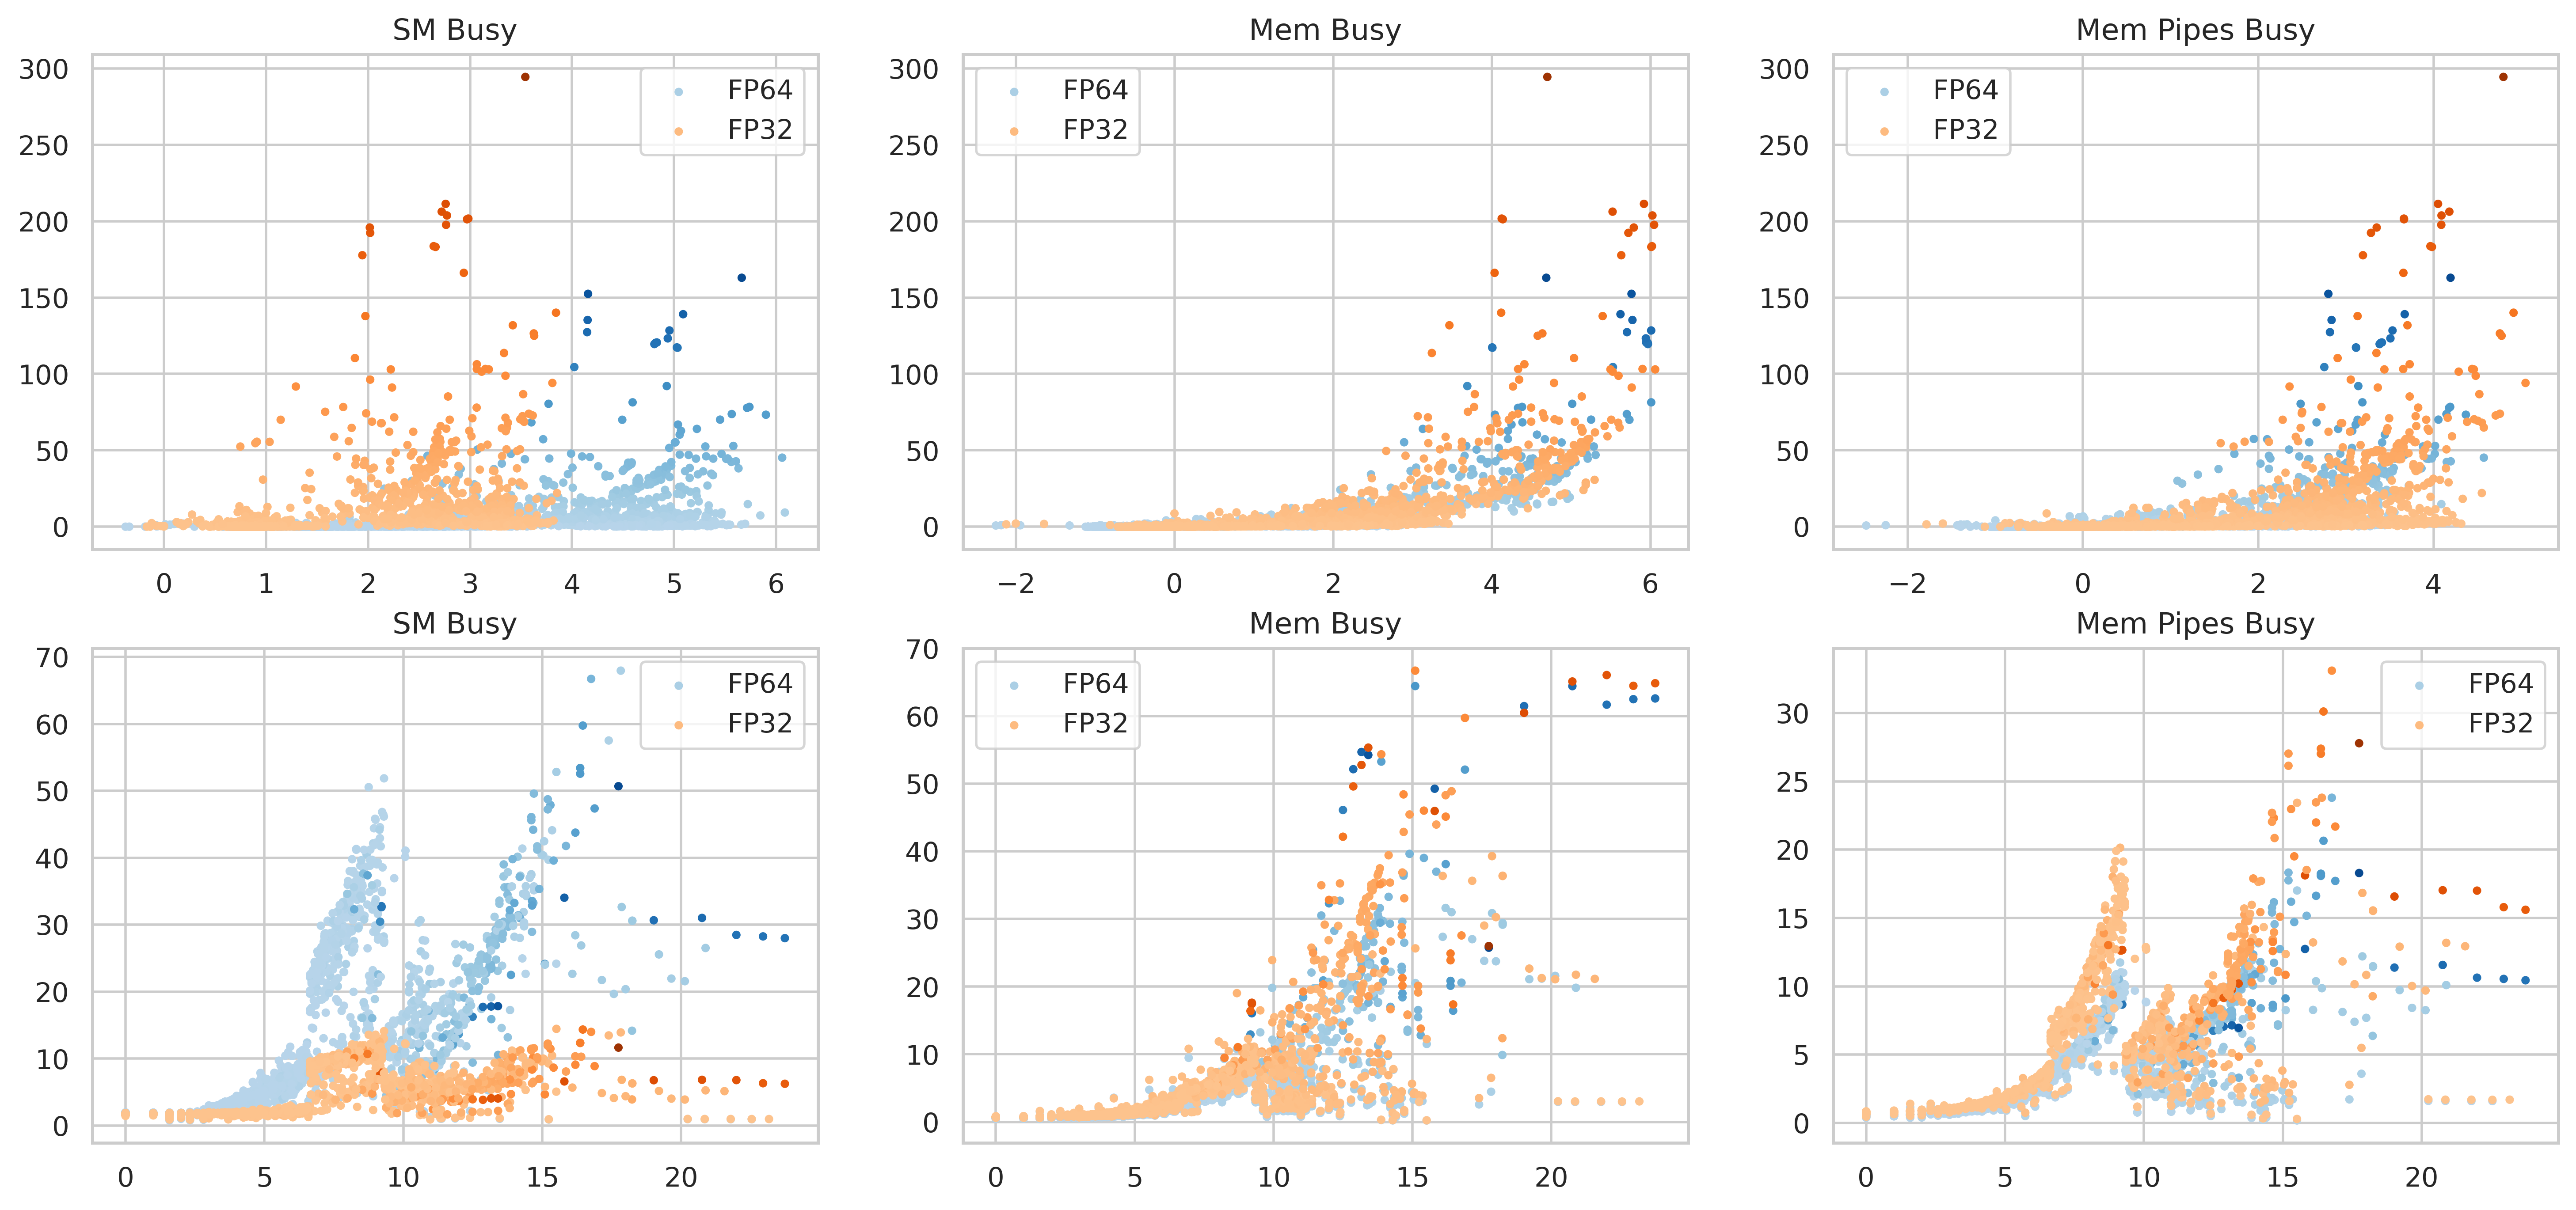

In [22]:
%matplotlib inline

plt.figure(figsize=(18, 8), dpi=400)
# plt.subplots_adjust(right=None, left=None,wspace=0.2, hspace=0)

mark_size= 6

plt.subplot(2,3,1)

plt.scatter(
    np.log2(df_all_64["sm_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["sm_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("SM Busy")

plt.subplot(2,3,2)

plt.scatter(
    np.log2(df_all_64["mem_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["mem_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("Mem Busy")

plt.subplot(2,3,3)

plt.scatter(
    np.log2(df_all_64["mem_pipe_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["mem_pipe_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("Mem Pipes Busy")

plt.subplot(2,3,4)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["sm_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["sm_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("SM Busy")

plt.subplot(2,3,5)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("Mem Busy")

plt.subplot(2,3,6)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_pipe_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_pipe_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("Mem Pipes Busy")

plt.show()

In [23]:
df_comp = pd.merge(df_all_32,
                   df_all_64,
                   on="parallelism_avg",
                   how="inner",
                   suffixes=("_32", "_64"))
df_comp["mem_busy_diff"] = df_comp["mem_busy_32"] / df_comp["mem_busy_64"]
df_comp["sm_busy_diff"] = df_comp["sm_busy_32"] / df_comp["sm_busy_64"]
df_comp["mem_pipe_busy_diff"] = df_comp["mem_pipe_busy_32"] / df_comp[
    "mem_pipe_busy_64"]
df_comp["L2_throughput_diff"] = df_comp["L2_throughput_32"] / df_comp["L2_throughput_64"]
df_comp["L2_rate_diff"] = df_comp["L2_rate_32"] / df_comp["L2_rate_64"]

print(df_comp)


               cu_pro_32                                             mat_32  \
0      exe_sptrsv_csr_32       /ssget/MM/Szczerba/Ill_Stokes/Ill_Stokes.cbd   
1      exe_sptrsv_csr_32          /ssget/MM/Freescale/FullChip/FullChip.cbd   
2      exe_sptrsv_csr_32      /ssget/MM/Freescale/Freescale1/Freescale1.cbd   
3      exe_sptrsv_csr_32  /ssget/MM/Freescale/circuit5M_dc/circuit5M_dc.cbd   
4      exe_sptrsv_csr_32        /ssget/MM/Freescale/transient/transient.cbd   
...                  ...                                                ...   
50658  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_3/CurlCurl_3.cbd   
50659  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_4/CurlCurl_4.cbd   
50660  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_1/CurlCurl_1.cbd   
50661  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_0/CurlCurl_0.cbd   
50662  exe_sptrsv_csr_32      /ssget/MM/Bodendiek/CurlCurl_2/CurlCurl_2.cbd   

         nnz_32  cu_time_32  cu_gflops_32  nlevel_3

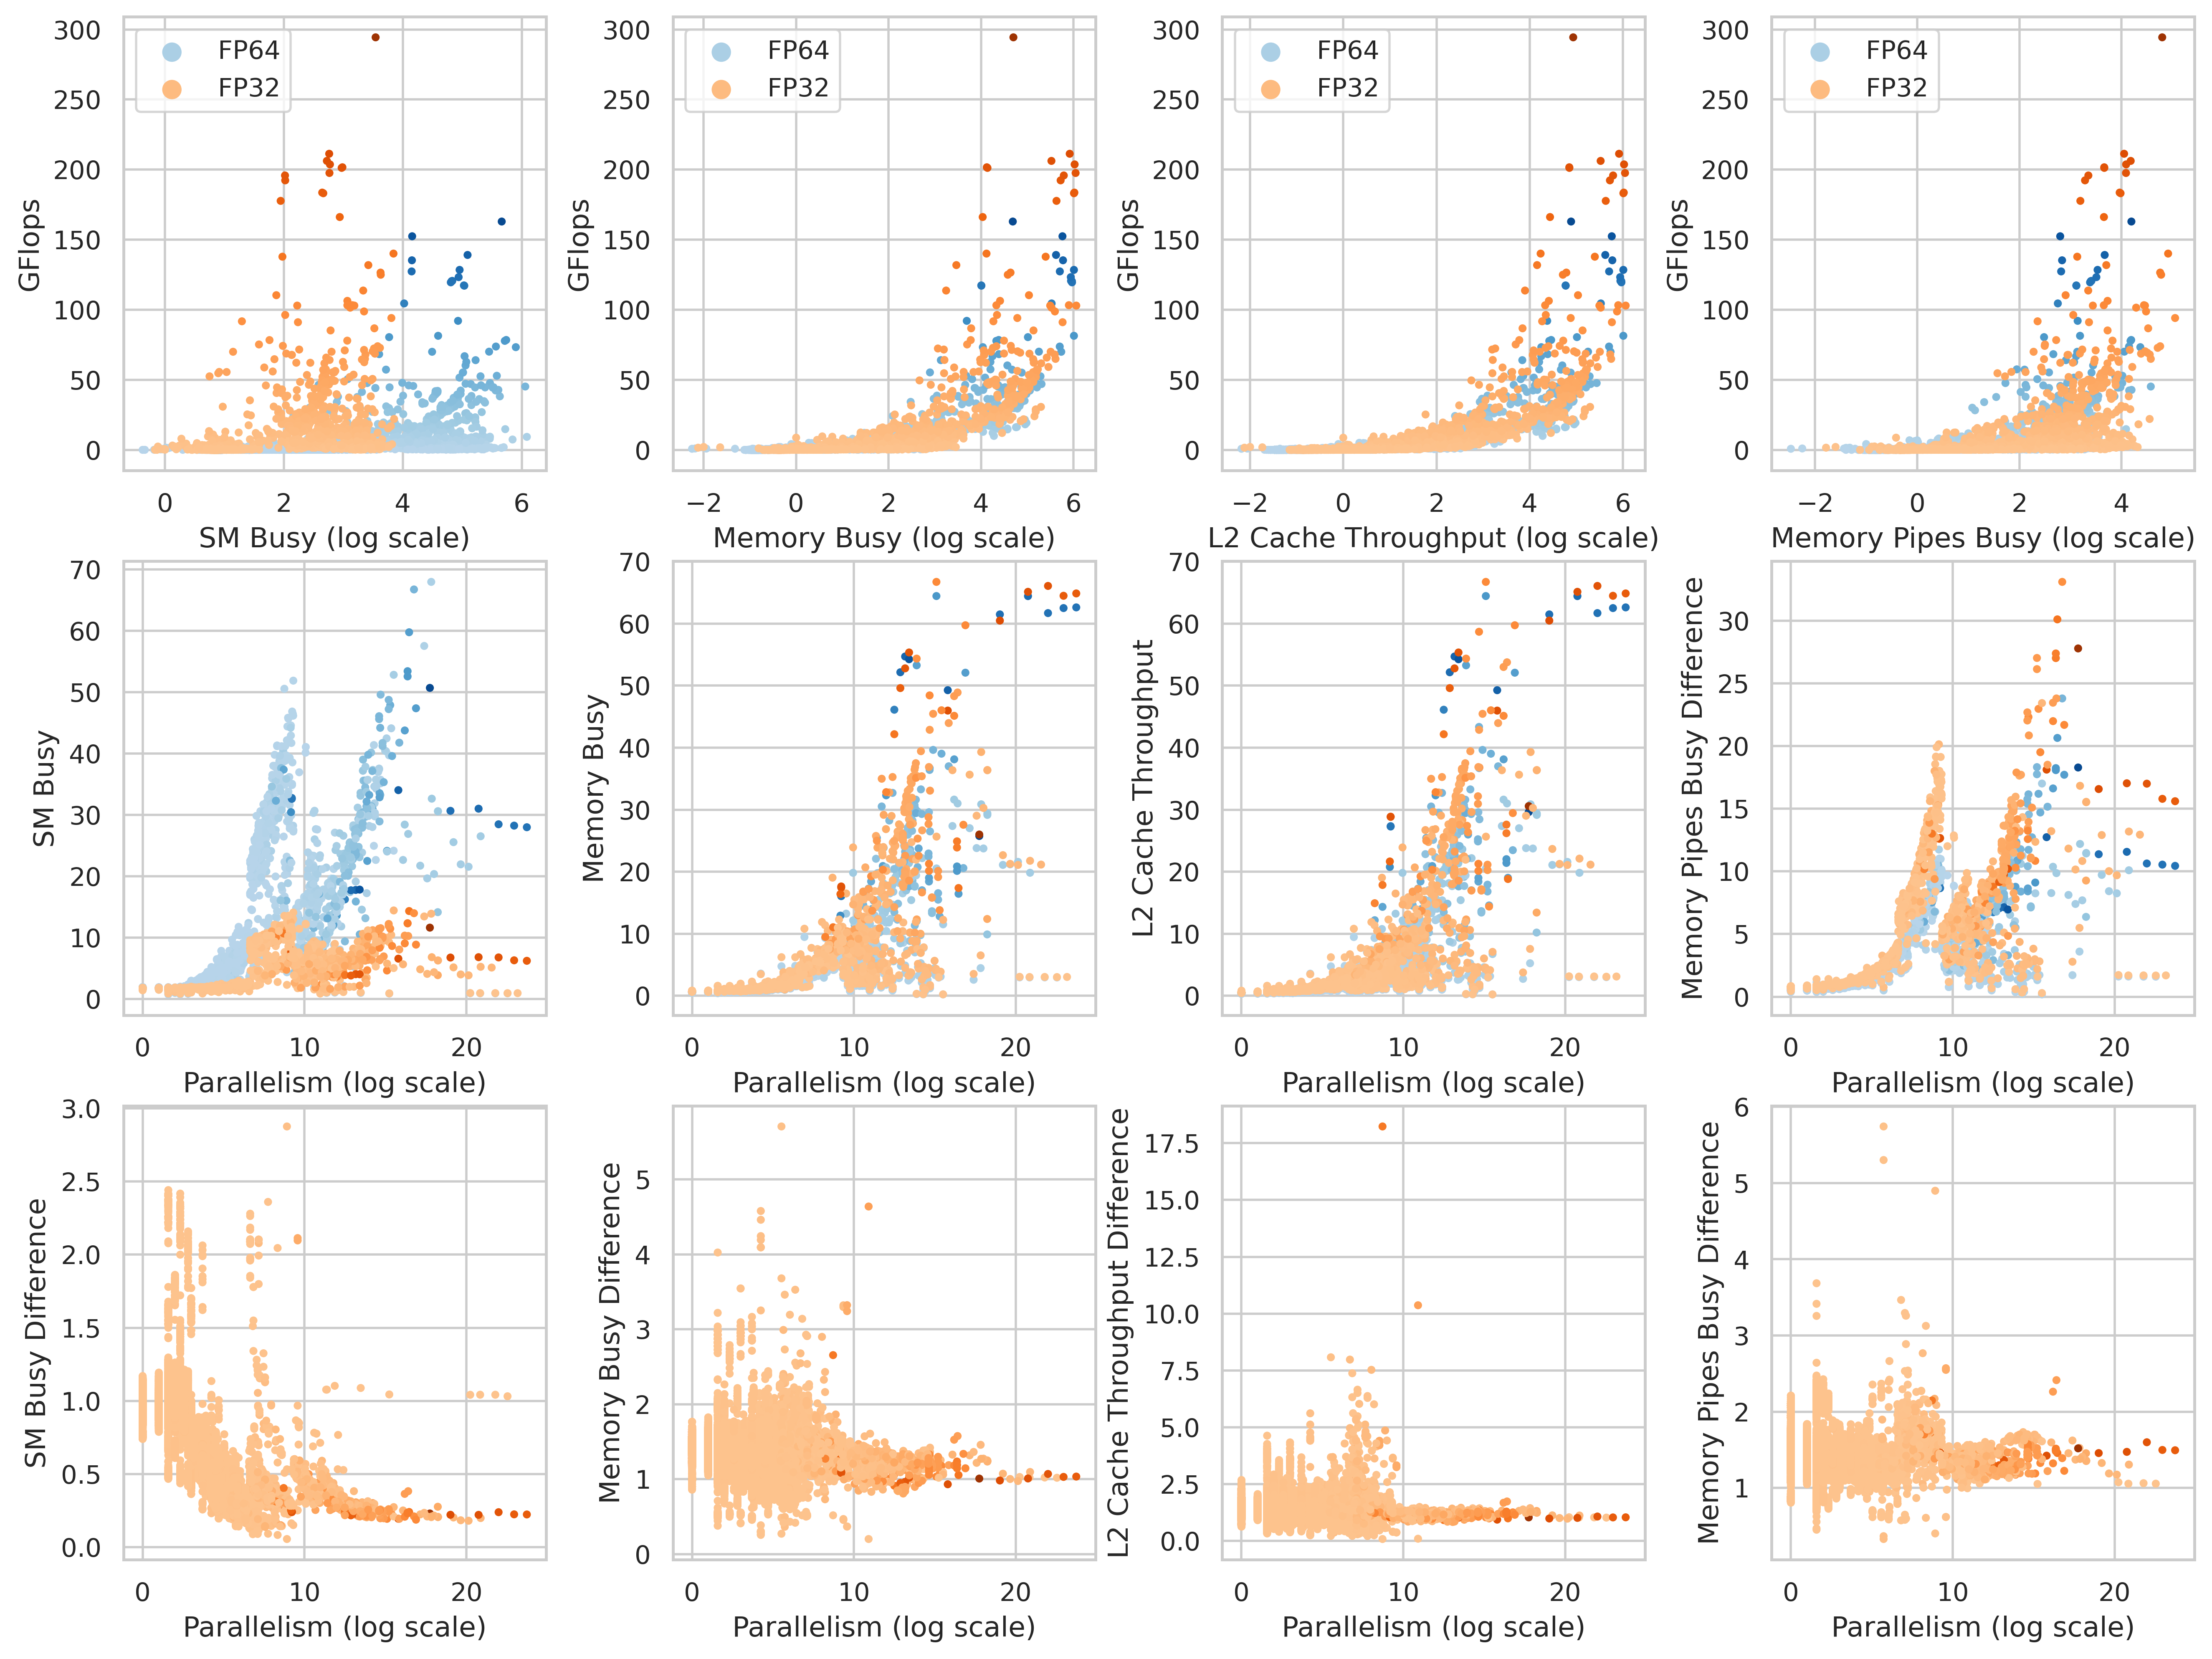

In [24]:
%matplotlib inline

fig, axs = plt.subplots(3, 4, figsize=(16, 12), dpi=400)
# plt.figure(figsize=(16, 12), dpi=400)

fig.subplots_adjust(right=None, left=None,wspace=0.3, hspace=0.2)
# fig.subplots_adjust(hspace=)

mark_size= 6

plt.subplot(3,4,1)

plt.scatter(
    np.log2(df_all_64["sm_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["sm_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend(loc=2, markerscale=3)
plt.xlabel("SM Busy (log scale)")
plt.ylabel("GFlops")

plt.subplot(3,4,2)

plt.scatter(
    np.log2(df_all_64["mem_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["mem_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend(loc=2, markerscale=3)
plt.xlabel("Memory Busy (log scale)")
plt.ylabel("GFlops")

plt.subplot(3,4,3)

plt.scatter(
    np.log2(df_all_64["L2_throughput"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["L2_throughput"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend(loc=2, markerscale=3)
plt.xlabel("L2 Cache Throughput (log scale)")
plt.ylabel("GFlops")

plt.subplot(3,4,4)

plt.scatter(
    np.log2(df_all_64["mem_pipe_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["mem_pipe_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend(loc=2, markerscale=3)

plt.xlabel("Memory Pipes Busy (log scale)")
plt.ylabel("GFlops")


plt.subplot(3,4,5)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["sm_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["sm_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
# plt.legend()
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
plt.ylabel("SM Busy")
plt.xlabel("Parallelism (log scale)")

plt.subplot(3,4,6)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
# plt.legend()
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
plt.ylabel("Memory Busy")
plt.xlabel("Parallelism (log scale)")

plt.subplot(3,4,7)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["L2_throughput"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["L2_throughput"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
# plt.legend()
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
plt.ylabel("L2 Cache Throughput")
plt.xlabel("Parallelism (log scale)")

plt.subplot(3,4,8)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_pipe_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_pipe_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
# plt.legend()
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
plt.ylabel("Memory Pipes Busy Difference")
plt.xlabel("Parallelism (log scale)")


plt.subplot(3,4,9)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["sm_busy_diff"]),
    c=(df_comp["cu_gflops_32"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Parallelism (log scale)")
plt.ylabel("SM Busy Difference")

plt.subplot(3,4,10)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["mem_busy_diff"]),
    c=(df_comp["cu_gflops_32"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Parallelism (log scale)")
plt.ylabel("Memory Busy Difference")


plt.subplot(3,4,11)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["L2_throughput_diff"]),
    c=(df_comp["cu_gflops_32"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Parallelism (log scale)")
plt.ylabel("L2 Cache Throughput Difference")

plt.subplot(3,4,12)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["mem_pipe_busy_diff"]),
    c=(df_comp["cu_gflops_32"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Parallelism (log scale)")
plt.ylabel("Memory Pipes Busy Difference")


plt.savefig ("sptrsv_ncu_4090.pdf", dpi= 400, format = "pdf", bbox_inches='tight', pad_inches=0.0) 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


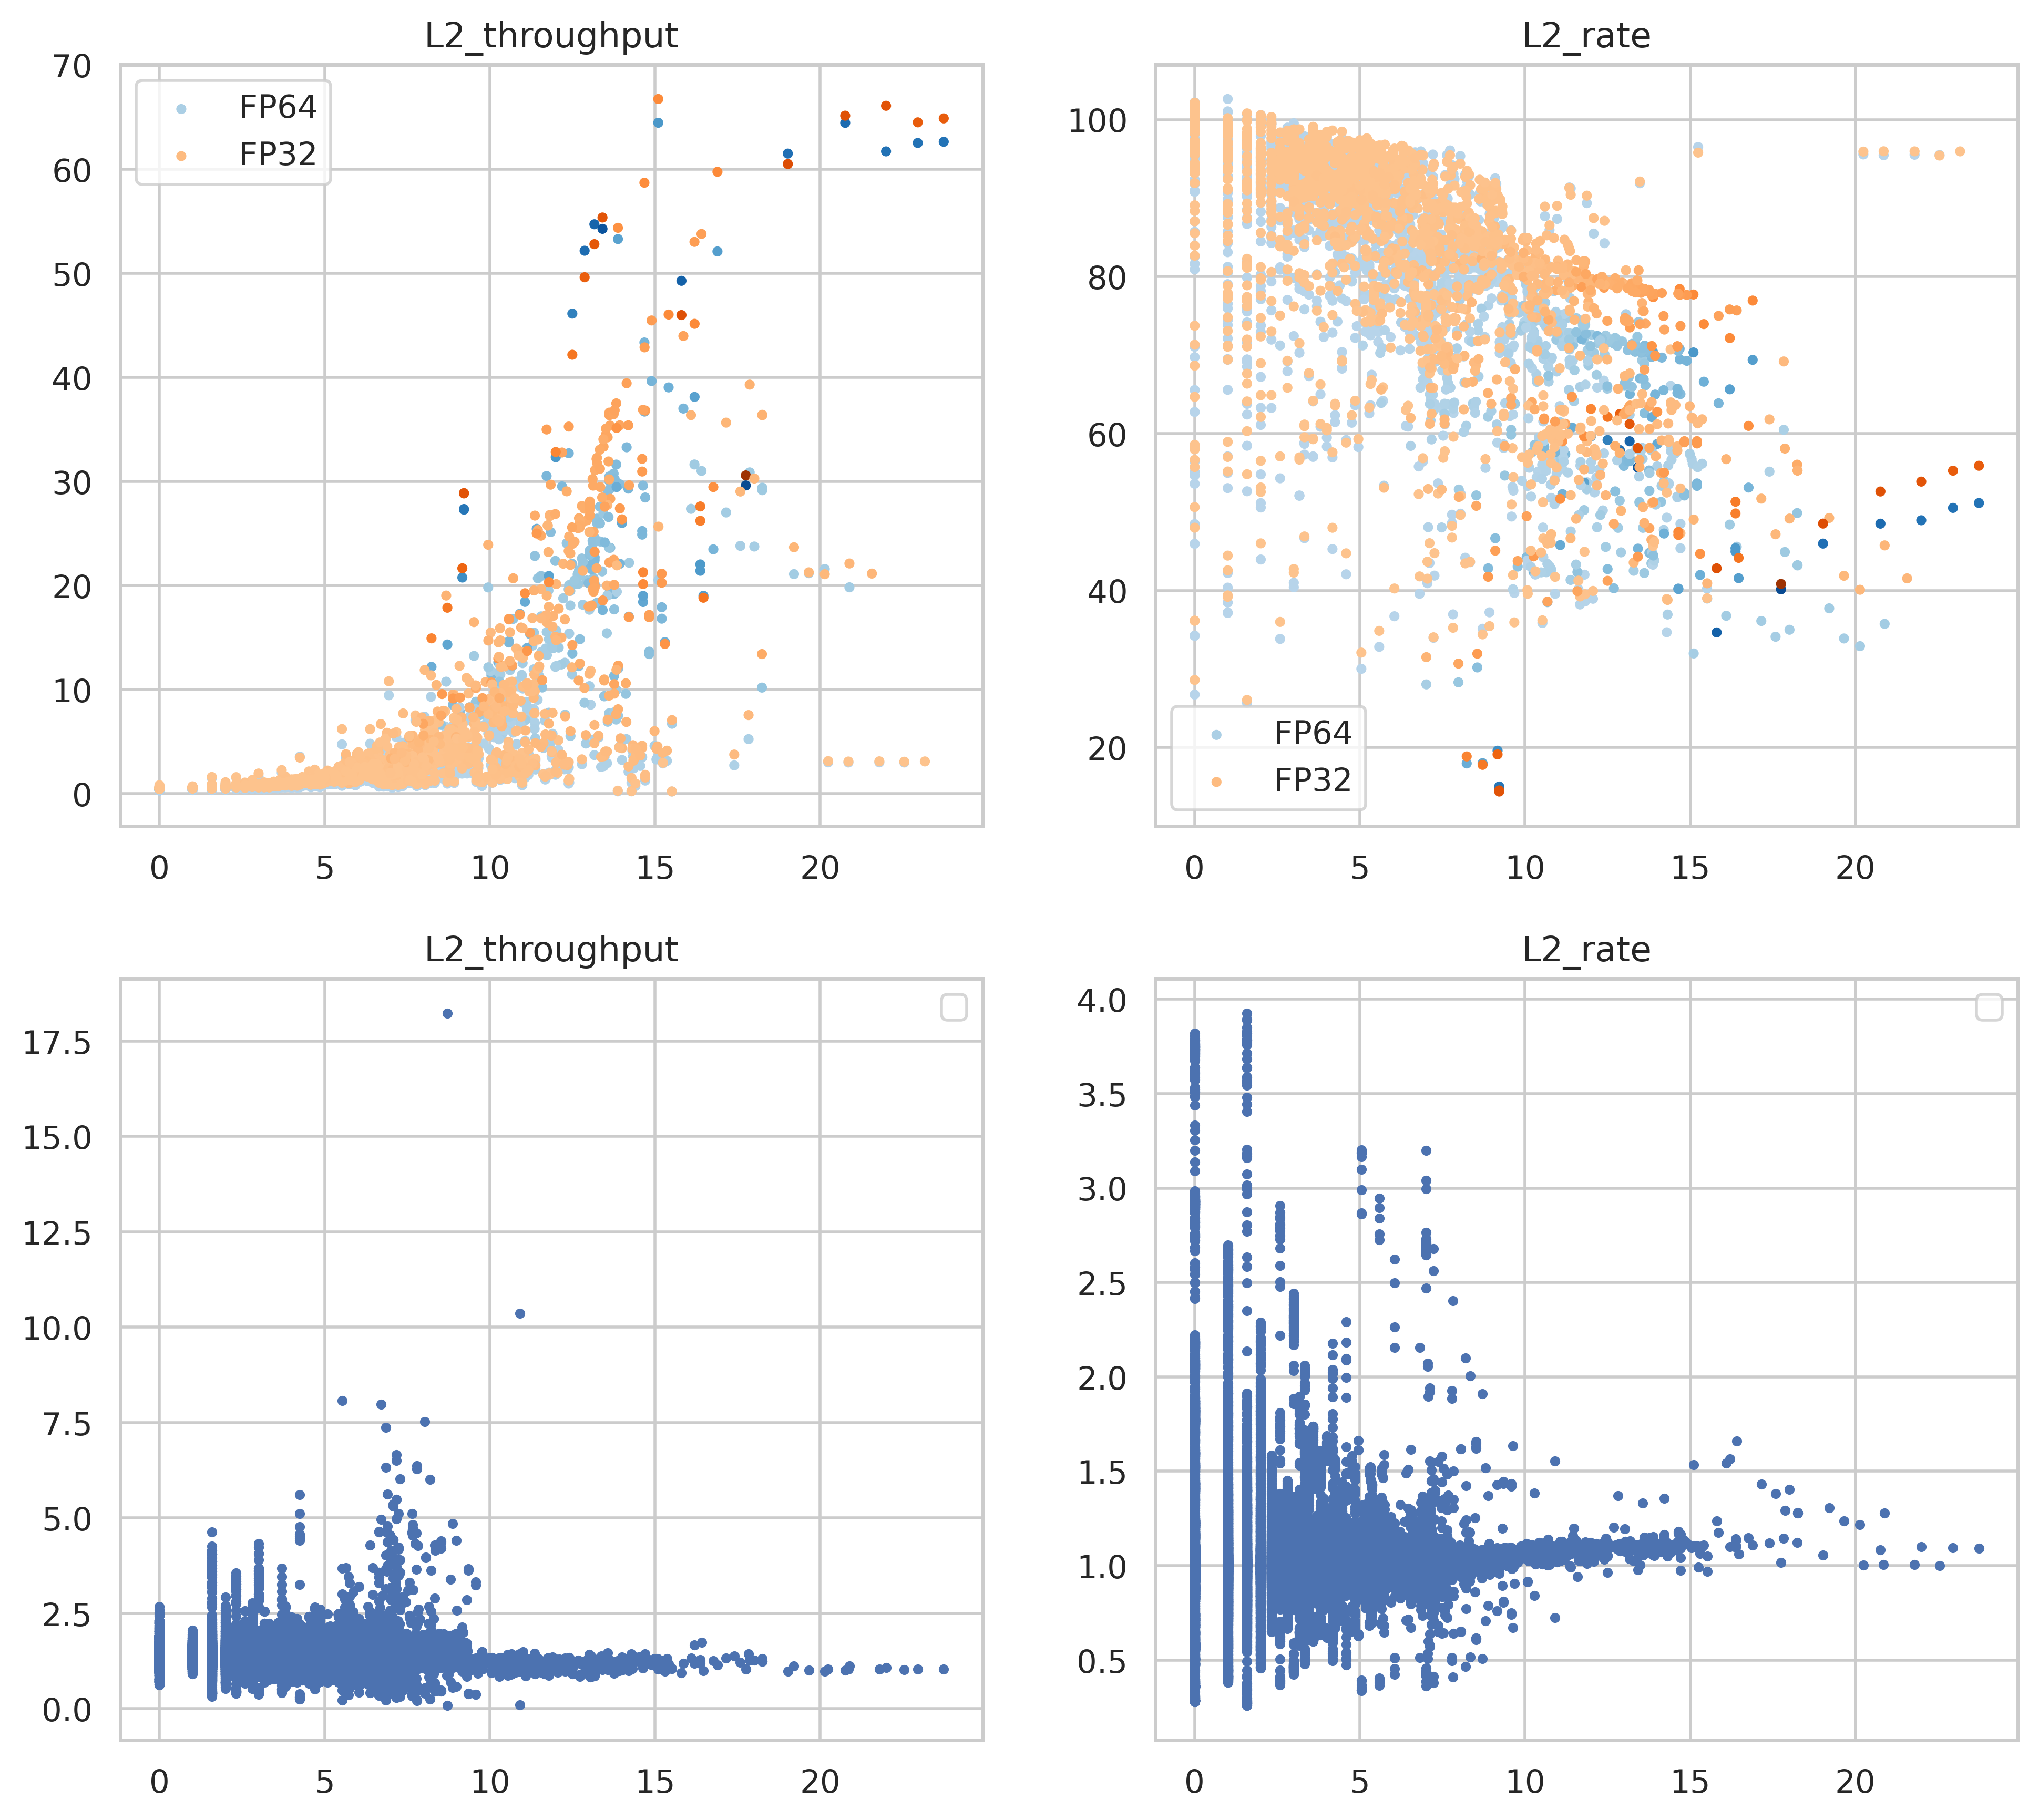

In [25]:
%matplotlib inline

plt.figure(figsize=(18, 16), dpi=400)
# plt.subplots_adjust(right=None, left=None,wspace=0.2, hspace=0)

mark_size= 6

plt.subplot(3,3,1)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["L2_throughput"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["L2_throughput"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("L2_throughput")

plt.subplot(3,3,2)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["L2_rate"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["L2_rate"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend()
plt.title("L2_rate")

plt.subplot(3,3,4)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["L2_throughput_diff"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.legend()
plt.title("L2_throughput")

plt.subplot(3,3,5)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["L2_rate_diff"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.legend()
plt.title("L2_rate")


plt.show()

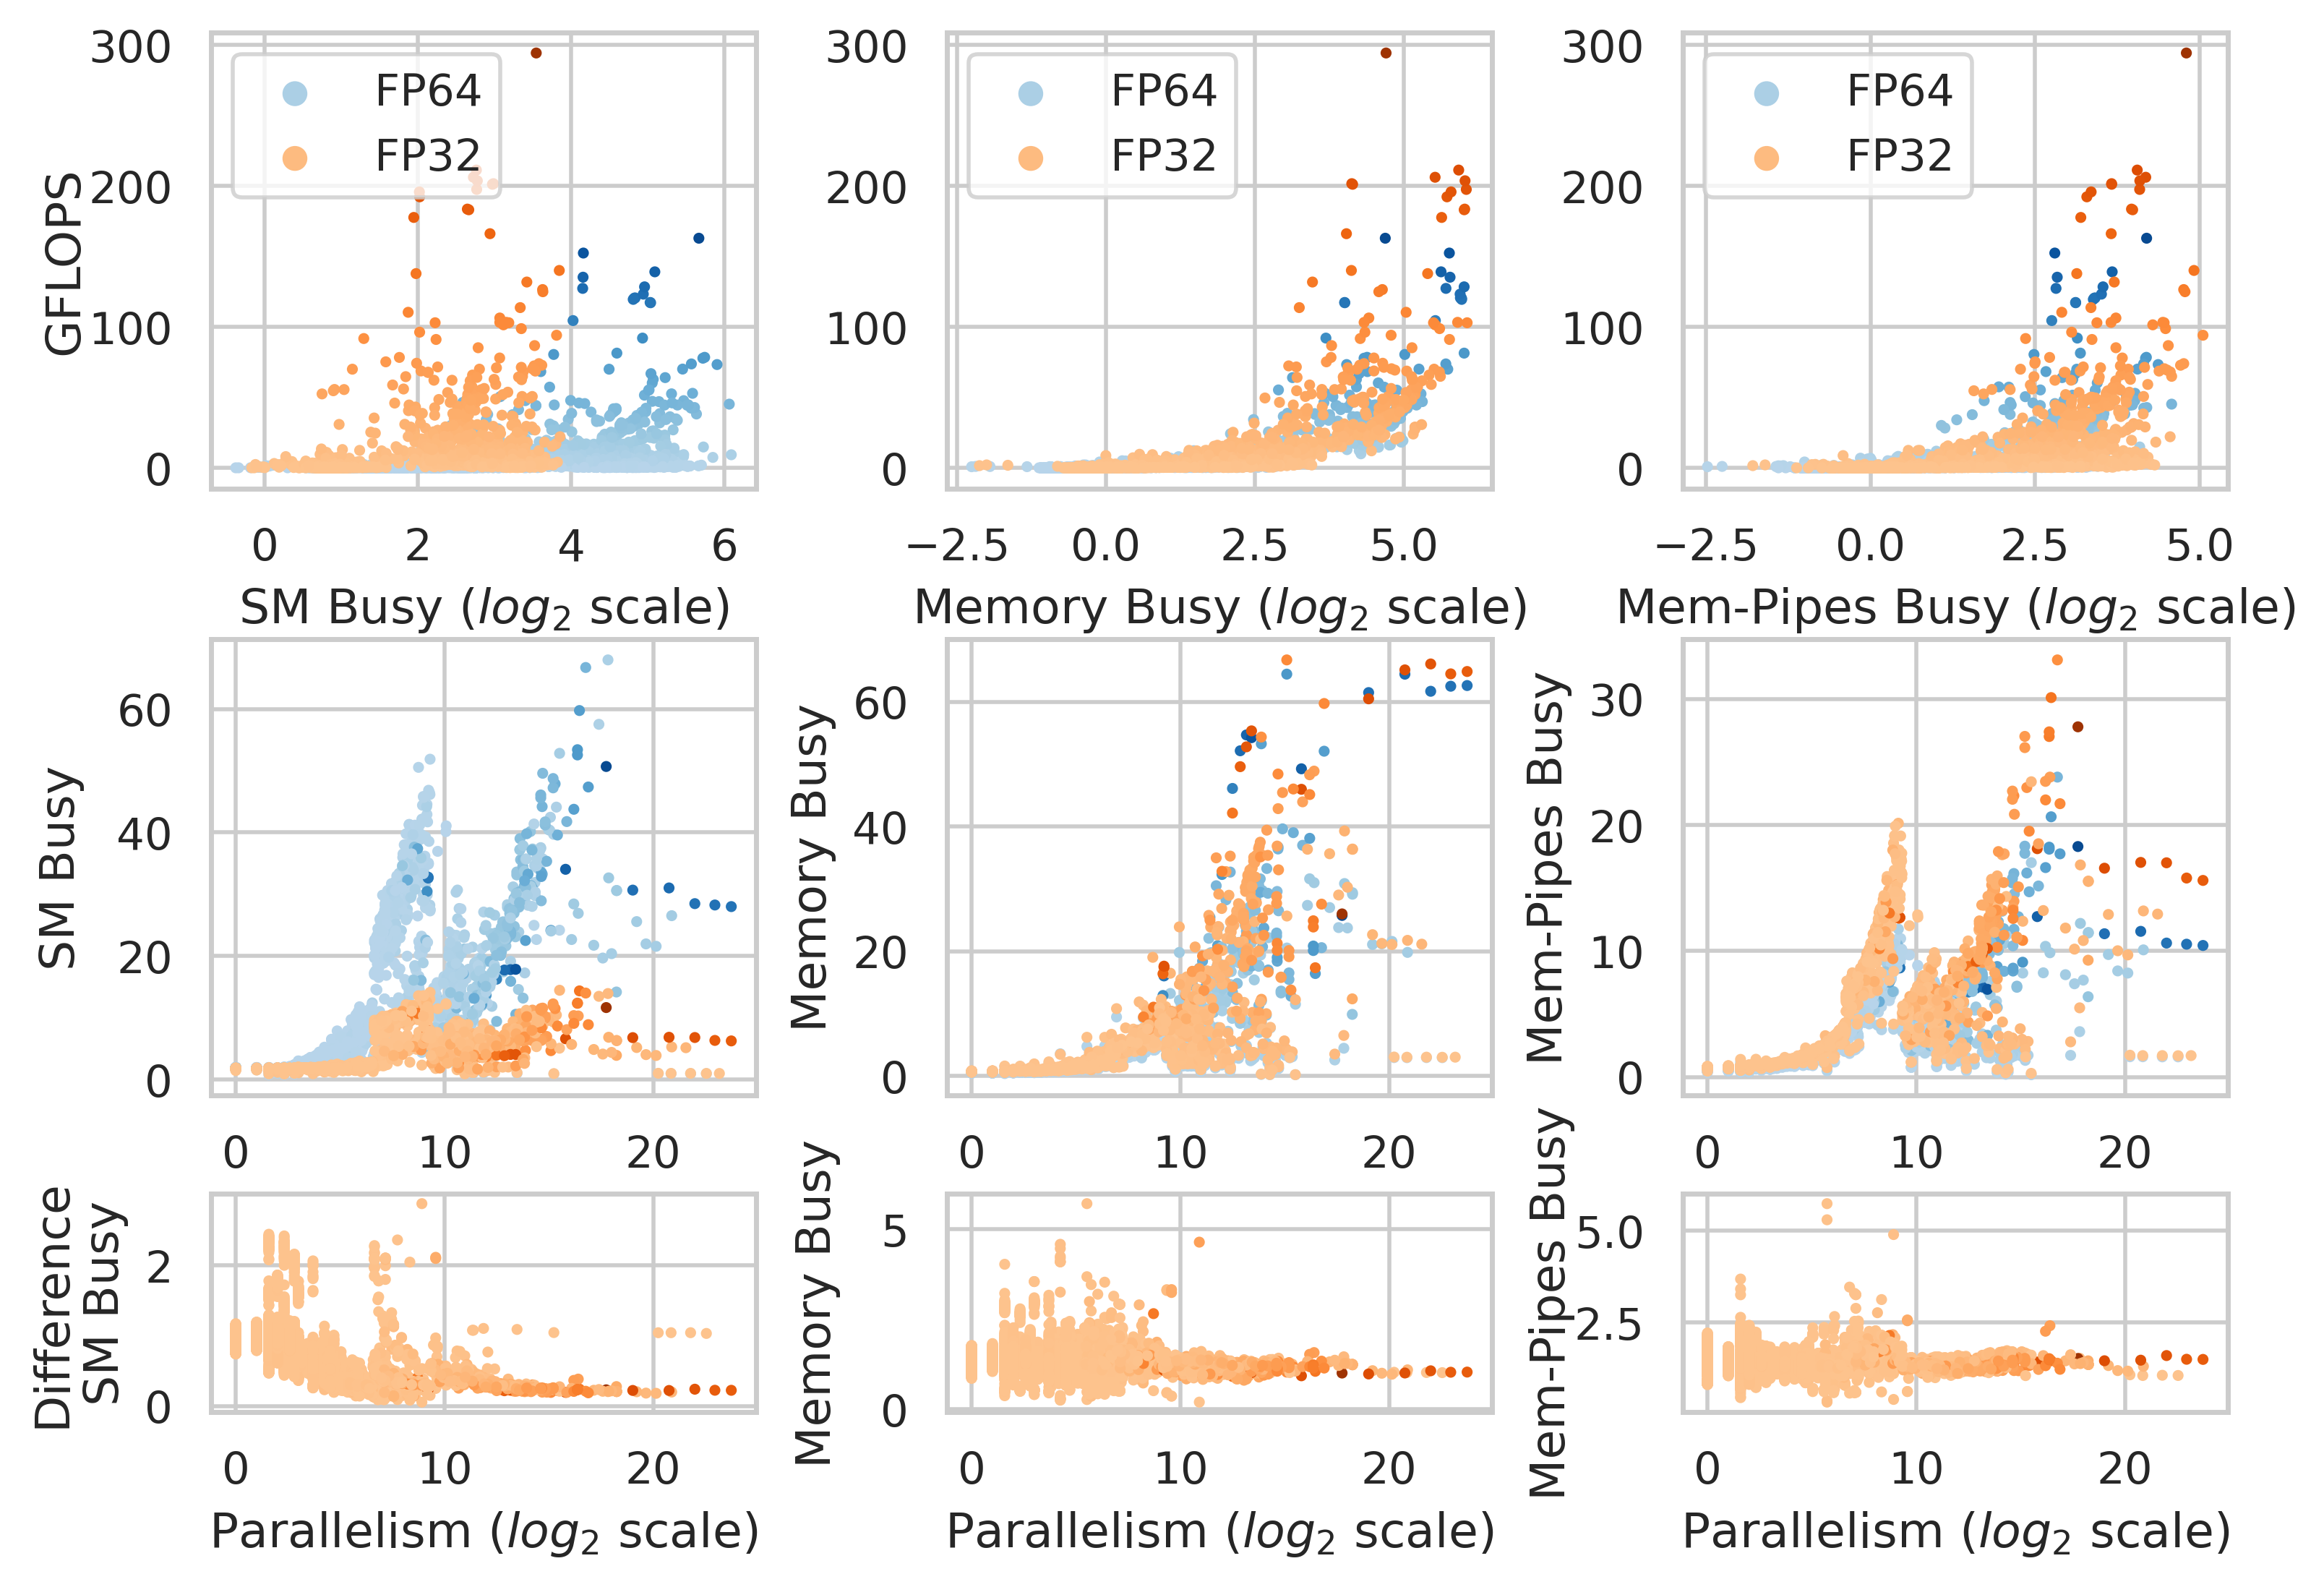

In [26]:
%matplotlib inline

# plt.subplots(3, 4, figsize=(8, 6), dpi=400)
plt.figure(figsize=(9, 7.5), dpi=400)

plt.subplots_adjust(right=None, left=None,wspace=0.35, hspace=0.33)

mark_size= 3

plt.subplot(3,3,1)

plt.scatter(
    np.log2(df_all_64["sm_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["sm_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend(loc=2, markerscale=3)
plt.xlabel("SM Busy ($log_2$ scale)")
plt.ylabel("GFLOPS",labelpad=-0.005)

plt.subplot(3,3,2)

plt.scatter(
    np.log2(df_all_64["mem_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["mem_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend(loc=2, markerscale=3)
plt.xlabel("Memory Busy ($log_2$ scale)")
# plt.ylabel("GFlops")

plt.subplot(3,3,3)

plt.scatter(
    np.log2(df_all_64["mem_pipe_busy"]),
    (df_all_64["cu_gflops"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["mem_pipe_busy"]),
    (df_all_32["cu_gflops"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.legend(loc=2, markerscale=3)

plt.xlabel("Mem-Pipes Busy ($log_2$ scale)")
# plt.ylabel("GFlops")


plt.subplot(3,3,4)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["sm_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["sm_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
# plt.legend()
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
plt.ylabel("SM Busy",labelpad=8)
# plt.xlabel("Parallelism (log scale)")

plt.subplot(3,3,5)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
# plt.legend()
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
plt.ylabel("Memory Busy")
# plt.xlabel("Parallelism (log scale)")

plt.subplot(3,3,6)

plt.scatter(
    np.log2(df_all_64["parallelism_avg"]),
    (df_all_64["mem_pipe_busy"]),
    label="FP64",
    c=(df_all_64["cu_gflops"]),
    cmap=cmap_64,
    s=mark_size,
)

plt.scatter(
    np.log2(df_all_32["parallelism_avg"]),
    (df_all_32["mem_pipe_busy"]),
    label="FP32",
    c=(df_all_32["cu_gflops"]),
    cmap=cmap_32,
    s=mark_size,
)
# plt.legend()
# ax = plt.gca()
# ax.axes.xaxis.set_ticklabels([])
plt.ylabel("Mem-Pipes Busy")
# plt.xlabel("Parallelism (log scale)")


plt.subplot(6,3,13)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["sm_busy_diff"]),
    c=(df_comp["cu_gflops_32"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Parallelism ($log_2$ scale)")
plt.ylabel("Difference\nSM Busy")

plt.subplot(6,3,14)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["mem_busy_diff"]),
    c=(df_comp["cu_gflops_32"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Parallelism ($log_2$ scale)")
plt.ylabel("Memory Busy",labelpad=10)


plt.subplot(6,3,15)

plt.scatter(
    np.log2(df_comp["parallelism_avg"]),
    (df_comp["mem_pipe_busy_diff"]),
    c=(df_comp["cu_gflops_32"]),
    cmap=cmap_32,
    s=mark_size,
)
plt.xlabel("Parallelism ($log_2$ scale)")
plt.ylabel("Mem-Pipes Busy",labelpad=-0.15)


plt.savefig ("sptrsv_ncu_4090_3.pdf", dpi= 400, format = "pdf", bbox_inches='tight', pad_inches=0.0) 
